In [82]:
import math
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import numpy as np

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import h5py
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from scipy import io
import xarray as xr
from PIL import Image

from rainnow.src.data_prep.data_processing import (
    load_imerg_h5_file_into_xarr,
    crop_xarr_using_lat_and_lon,
)
from rainnow.src.plotting import geoplot_raw_imerg_xarray_tile

import imageio
from rainnow.src.configs.config import IMERG_CROP

In [83]:
# load in custom colour map.
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
box_params = {"color": "red", "linestyle": "--", "linewidth": 1}
rain_cmap = ListedColormap(cmap["Cmap_rain"])

plot_params = {"cmap": rain_cmap, "vmin": 0.1, "vmax": 10}
cbar_params = {"orientation": "horizontal", "pad": 0.05, "fraction": 0.01, "aspect": 60}
global_params = {
    "font.size": 10,
    # "font.family": "Times New Roman"
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
box_params = {"color": "red", "linestyle": "--", "linewidth": 1}

In [76]:
def eq_straight_line(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    return m, c

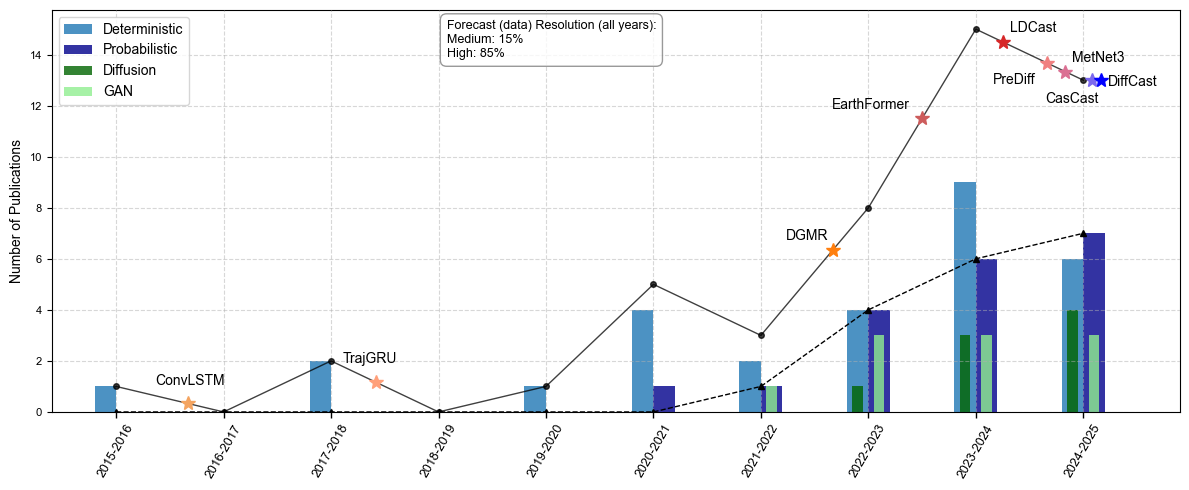

In [308]:
# get (and format) data.
df = pd.read_csv('irp-presentation-data.csv')
df['paper_date'] = pd.to_datetime(df['paper_date'], format='%b-%y')
df['year'] = df['paper_date'].dt.year
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# sort out data.
all_years = range(2015, 2025)
yearly_counts = df.groupby(['year', 'method']).size().unstack(fill_value=0)
yearly_counts = yearly_counts.reindex(all_years, fill_value=0)
bar_width = 0.2
r1 = np.arange(len(all_years))
r2 = [x + bar_width for x in r1]

# create bar plot.
fig, ax = plt.subplots(figsize=(12, 5))
plt.rcParams['font.family'] = 'Arial'
ax.bar(r1, yearly_counts['deterministic'], color='C0', width=bar_width, label='Deterministic', alpha=0.8, zorder=2)
ax.bar(r2, yearly_counts['probabilistic'], color='darkblue', width=bar_width, label='Probabilistic', alpha=0.8, zorder=2)
total_counts = yearly_counts.sum(axis=1)
line = ax.plot(r1 + bar_width/2,
               total_counts,
               color='black',
               marker='o',
               label='',
               linewidth=1,
               markersize=4,
               alpha=0.75,
               zorder=3
               )

# add in base_model bars.
df_bm_filtered = df[df['base_model'].isin(['GAN', 'Diffusion'])]
bm_yearly_counts = df_bm_filtered.groupby(['year', 'base_model']).size().unstack(fill_value=0)
yearly_counts_bm = bm_yearly_counts.reindex(all_years, fill_value=0)
total_counts_bm = yearly_counts_bm.sum(axis=1)
line = ax.plot(r1 + bar_width/2,
               total_counts_bm,
               color='black',
               marker='^',
               label='',
               linewidth=1,
               linestyle='dashed',
               markersize=4,
               alpha=1,
               zorder=3
               )
ax.bar(r1, yearly_counts_bm['Diffusion'], color='darkgreen', width=bar_width/2, label='Diffusion', alpha=0.8, zorder=2)
ax.bar(r2, yearly_counts_bm['GAN'], color='lightgreen', width=bar_width/2, label='GAN', alpha=0.8, zorder=2)

# plot markers + annotations for specific, important papers.
papers = {
    "PreDiff": ("2023-09-01", "lightcoral", (-.575, -1.2)),
    "CasCast": ("2024-02-01", "mediumslateblue", (-.5, -1.3)),
    "DiffCast": ("2024-03-01", "blue", (0, -.6)),
    "DGMR": ("2021-09-01", "C1", (-.5, 0)),
    "MetNet3": ("2023-11-01", "palevioletred", (0, 0)),
    "ConvLSTM": ("2015-09-01", "sandybrown", (-.37, .35)),
    "TrajGRU": ("2017-06-01", "lightsalmon", (-.37, .35)),
    "LDCast": ("2023-04-01", "C3", (0, 0)),
    "EarthFormer": ("2022-07-01", "indianred", (-.9, 0)),
}

for paper, (date, color, offset) in papers.items():
    date = pd.to_datetime(date)
    year, month = date.year, date.month
    x1, y1 = year, total_counts.values[year - 2015]
    x2, y2 = year + 1, total_counts.values[year - 2014] if year < 2024 else total_counts.values[year - 2015]

    # get interpolated coords.
    m, c = eq_straight_line(x1, y1, x2, y2)
    x = year + (month - 1) / 12
    y = m * x + c

    # plot + annotate.
    ax.plot(x - 2015 + bar_width/2, y, marker='*', markersize=10, color=color, label='', zorder=4)
    ax.annotate(paper, ((x - 2015 + bar_width/2)+offset[0], y+offset[1]), xytext=(5, 5), 
                textcoords='offset points', fontsize=10, rotation=0, ha='left', va='bottom')
    

ax.text(0.35, 0.975, 'Forecast (data) Resolution (all years):\nMedium: 15%\nHigh: 85%', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top', 
        horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8))


# global params.
plt.grid(True, axis='both', linestyle='--', alpha=0.5, zorder=0)
ax.set_xlim(-0.5, len(all_years) - 0.5 + 0.5)
ax.set_xticks(r1 + bar_width/2)
ax.set_xticklabels([f'{year}-{year+1}' for year in all_years], rotation=60, fontsize=9)
ax.tick_params(axis='x', which='major', color='black', length=4, width=1)
ax.set_ylabel('Number of Publications', fontsize=10)
ax.legend(loc="best")
# ax.legend(loc='upper left', bbox_to_anchor=(0, .85))
ax.set_axisbelow(False)

plt.tight_layout()
plt.show()

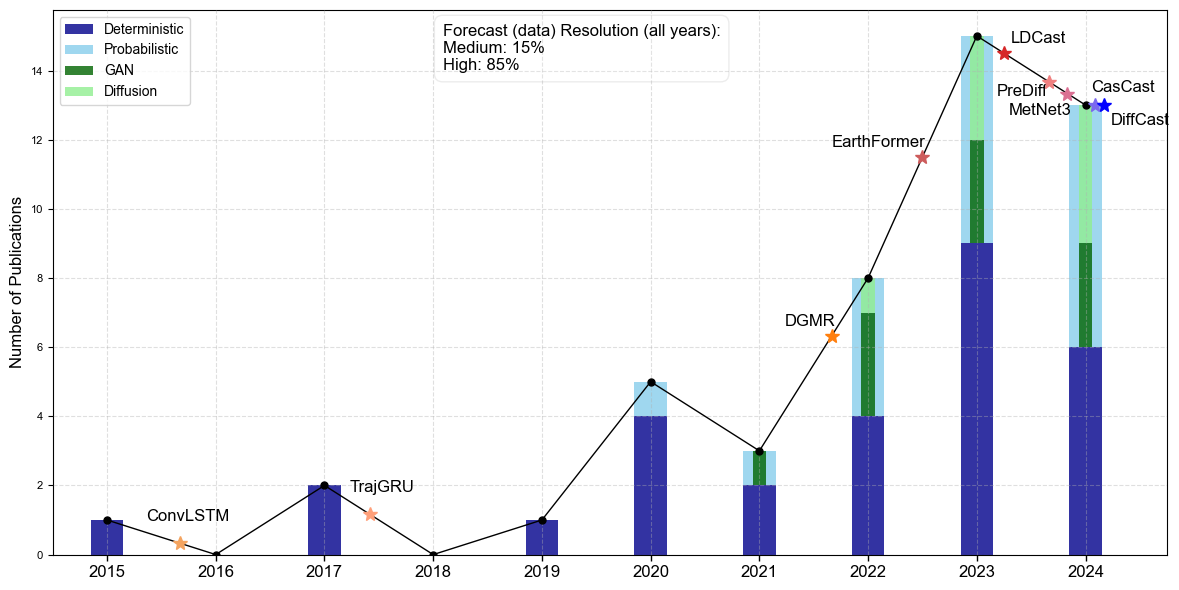

In [392]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get and format data
df = pd.read_csv('irp-presentation-data.csv')
df['paper_date'] = pd.to_datetime(df['paper_date'], format='%b-%y')
df['year'] = df['paper_date'].dt.year
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Sort out data
all_years = range(2015, 2025)
yearly_counts = df.groupby(['year', 'method']).size().unstack(fill_value=0)
yearly_counts = yearly_counts.reindex(all_years, fill_value=0)

# Get base model data
df_bm_filtered = df[df['base_model'].isin(['GAN', 'Diffusion'])]
bm_yearly_counts = df_bm_filtered.groupby(['year', 'base_model']).size().unstack(fill_value=0)
yearly_counts_bm = bm_yearly_counts.reindex(all_years, fill_value=0)

# Define bar width
bar_width1, bar_width2 = 0.3, 0.125

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams['font.family'] = 'Arial'

# Calculate the bottom values for GAN and Diffusion
bottom_values = yearly_counts['deterministic'] # + yearly_counts['probabilistic']

# Create the stacked bar chart
alpha = 0.8
ax.bar(all_years, yearly_counts['deterministic'], width=bar_width1, label='Deterministic', alpha=alpha, zorder=2, color="darkblue")
ax.bar(all_years, yearly_counts['probabilistic'], width=bar_width1, bottom=yearly_counts['deterministic'], label='Probabilistic', alpha=alpha, zorder=2, color="skyblue")
ax.bar(all_years, yearly_counts_bm['GAN'], width=bar_width2, bottom=bottom_values, label='GAN', alpha=alpha, zorder=2, color="darkgreen")
ax.bar(all_years, yearly_counts_bm['Diffusion'], width=bar_width2, bottom=bottom_values + yearly_counts_bm['GAN'], label='Diffusion', alpha=alpha, zorder=2, color="lightgreen")

# Total counts lines
total_counts = yearly_counts.sum(axis=1)
ax.plot(all_years, total_counts, color='black', marker='o', label='', linewidth=1, linestyle='solid', markersize=5, alpha=1, zorder=3)

# Plot markers + annotations for specific, important papers
papers = {
    "PreDiff": ("2023-09-01", "lightcoral", (-.55, -0.7)),
    "CasCast": ("2024-02-01", "mediumslateblue", (-.1, .1)),
    "DiffCast": ("2024-03-01", "blue", (0, -.85)),
    "DGMR": ("2021-09-01", "C1", (-.5, 0)),
    "MetNet3": ("2023-11-01", "palevioletred", (-0.6, -0.9)),
    "ConvLSTM": ("2015-09-01", "sandybrown", (-.37, .35)),
    "TrajGRU": ("2017-06-01", "lightsalmon", (-.25, .35)),
    "LDCast": ("2023-04-01", "C3", (0, 0)),
    "EarthFormer": ("2022-07-01", "indianred", (-.9, 0)),
}

def eq_straight_line(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    return m, c

for paper, (date, color, offset) in papers.items():
    date = pd.to_datetime(date)
    year, month = date.year, date.month
    x1, y1 = year, total_counts.values[year - 2015]
    x2, y2 = year + 1, total_counts.values[year - 2014] if year < 2024 else total_counts.values[year - 2015]

    # Get interpolated coords
    m, c = eq_straight_line(x1, y1, x2, y2)
    x = year + (month - 1) / 12
    y = m * x + c

    # Plot + annotate
    ax.plot(x, y, marker='*', markersize=10, color=color, label='', zorder=4)
    ax.annotate(paper, (x+offset[0], y+offset[1]), xytext=(5, 5), 
                textcoords='offset points', fontsize=12, rotation=0, ha='left', va='bottom')

ax.text(0.35, 0.975, 'Forecast (data) Resolution (all years):\nMedium: 15%\nHigh: 85%', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.15))

# Global params
plt.grid(True, axis='both', linestyle='--', alpha=0.4, zorder=0)
ax.set_xlim(2014.5, 2024.75)
ax.set_xticks(all_years)
# ax.set_xticklabels([f'{year}-{year+1}' for year in all_years], rotation=60, fontsize=12)
ax.set_xticklabels([f'{year}' for year in all_years], rotation=0, fontsize=12)
ax.tick_params(axis='x', which='major', color='black', length=4, width=1)
ax.set_ylabel('Number of Publications', fontsize=12)
ax.legend(loc="best", fontsize=10)
ax.set_axisbelow(False)

plt.tight_layout()
plt.show()

#### `...`

In [79]:
# cyclone YUKA - chosen visual case study --> effects Ecuador, Peru and North-Western
file_path = "/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S030000-E032959.0180.V07B.RT-H5"
imerg_tile = load_imerg_h5_file_into_xarr(file_path=file_path)
imerg_tile = crop_xarr_using_lat_and_lon(
    xarr=imerg_tile, lat_lims=(-89.95, 89.95), lon_lims=(-179.95, 179.95)
)
print(imerg_tile.shape)

(1800, 3600)


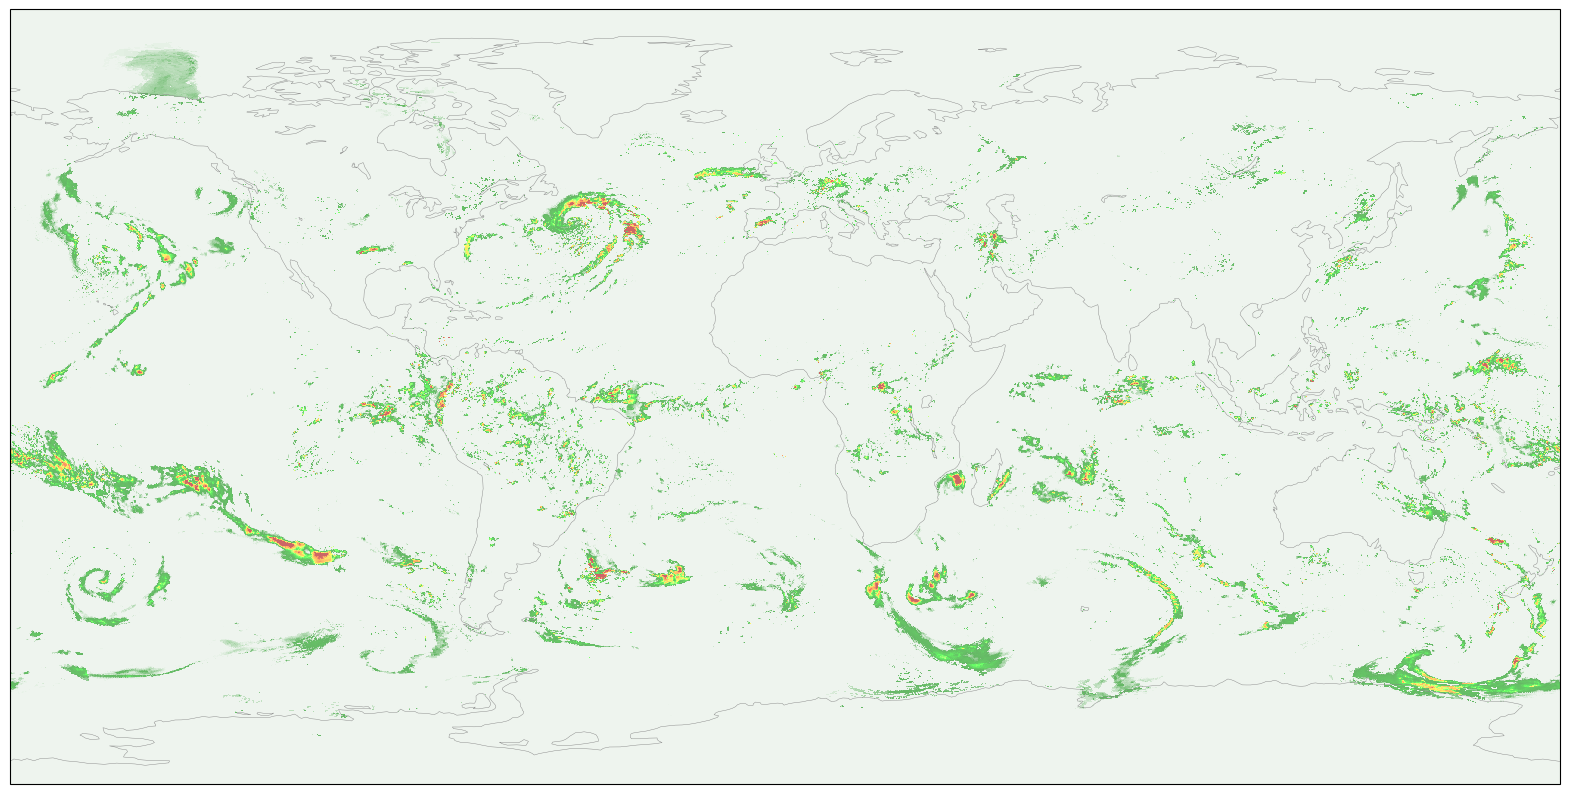

In [80]:
# plot the raw imerg tile but with geo features.
fig, ax = geoplot_raw_imerg_xarray_tile(
    imerg_tile=imerg_tile,
    projection=ccrs.PlateCarree(),
    plot_params={"cmap": rain_cmap, "vmin": 0.1, "vmax": 10, "alpha": 0.6},
    cbar_params=None,
    geo_params={"linewidth": 0.3},
    global_params={
        "font.size": 13,
    },
    remove_axes_ticks=True,
    figsize=(20, 20),
)

In [85]:
days = [
    # "2023/03/07",  # cyclone YAKU (peru and ecuador).
    "2023/03/08",
    # "2023/03/09",
    # "2023/03/10",
]
file_paths = []
for day in days:
    for fp in os.listdir(f"/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/{day}/"):
        if fp.split(".")[-1] == "RT-H5":
            file_paths.append(f"/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/{day}/{fp}")

# create a directory to save the frames.
frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)

for idx, file_path in enumerate(file_paths):
    imerg_tile = load_imerg_h5_file_into_xarr(file_path=file_path)
    imerg_tile = crop_xarr_using_lat_and_lon(
        xarr=imerg_tile,
        lat_lims=IMERG_CROP["inner"]["latitude"],
        lon_lims=IMERG_CROP["inner"]["longitude"],
    )

    # geoplot: plot the raw imerg tile but with geo features.
    fig, ax = geoplot_raw_imerg_xarray_tile(
        imerg_tile=imerg_tile,
        projection=ccrs.PlateCarree(),
        plot_params=plot_params,
        cbar_params=None,
        global_params=global_params,
        figsize=(6, 6),
        remove_axes_ticks=True,
        geo_params={'linewidth': 0.5},
    )
    ax.axis("off")
    # ax.set_title(file_path.split("/")[-1].split(".")[-4])
    frame_path = os.path.join(frames_dir, f"frame_{idx:03d}.png")
    plt.savefig(frame_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# create gif from frames.
frames = []
for idx in range(len(file_paths)):
    frame_path = os.path.join(frames_dir, f"frame_{idx:03d}.png")
    frames.append(imageio.imread(frame_path))

gif_path = "imerg_ppt_gif.gif"
imageio.mimsave(gif_path, frames, duration=0.5)

/var/folders/1k/vm_h9ycj6d9020w63h786g5w0000gp/T/ipykernel_6326/2527770344.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


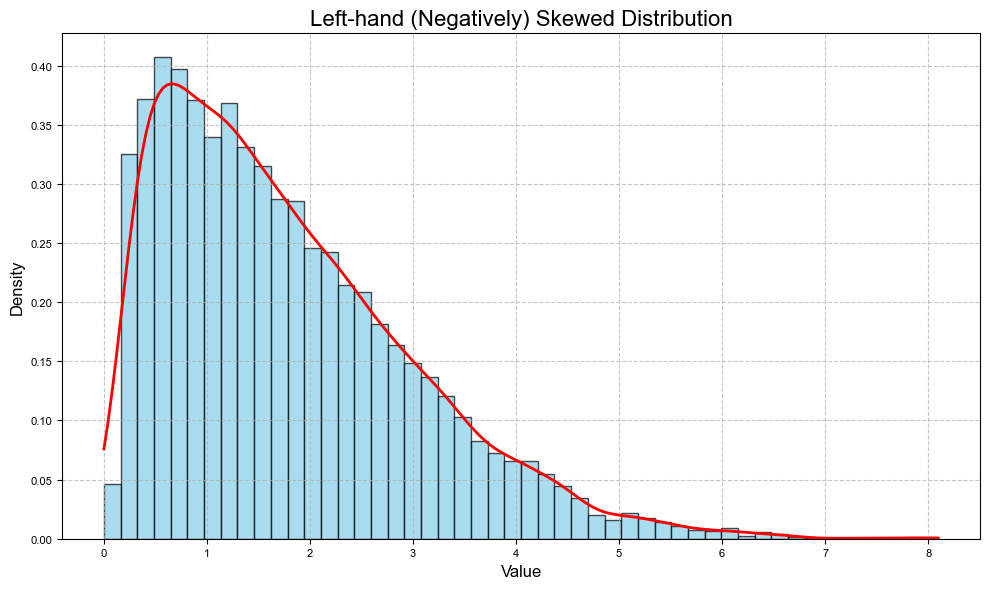

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# Set random seed for reproducibility
np.random.seed(42)

# Generate left-skewed data
a = 30  # skewness parameter
data = skewnorm.rvs(a, loc=1, scale=2, size=10000)

# Ensure all values are positive
data = data - np.min(data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Add a kernel density estimate
from scipy.stats import gaussian_kde
kde = gaussian_kde(data)
x_range = np.linspace(data.min(), data.max(), 200)
plt.plot(x_range, kde(x_range), 'r-', lw=2)

# Customize the plot
plt.title('Left-hand (Negatively) Skewed Distribution', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

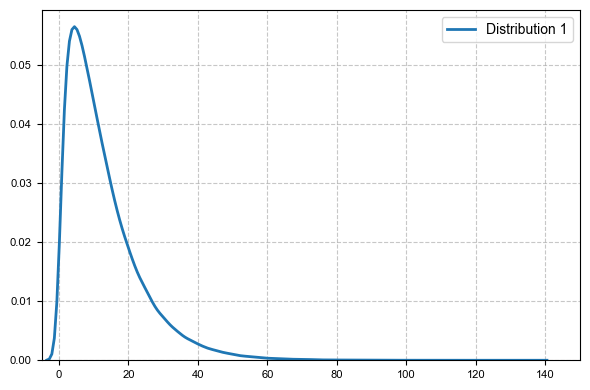

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import exponweib

np.random.seed(42)

# Generate data using exponential-Weibull distribution
a1, c1, scale1 = 1.5, 1, 10
size = 500000

data = exponweib.rvs(a1, c1, scale=scale1, size=size)

fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(data, linewidth=2, bw_adjust=1.5, ax=ax, label='Distribution 1')

ax.set_ylabel("")
ax.set_xlim(-5, 150)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [258]:
f(np.linspace(x1, x2, 100))

array([0.05617637, 0.0559451 , 0.05555019, 0.05515528, 0.05469906,
       0.05415224, 0.05360542, 0.05300296, 0.05235276, 0.05170257,
       0.05101633, 0.05031258, 0.04960884, 0.04888949, 0.04816642,
       0.04744335, 0.04670752, 0.04597091, 0.04523325, 0.04448307,
       0.0437329 , 0.04298194, 0.04222808, 0.04147422, 0.04072444,
       0.03998235, 0.03924026, 0.03850916, 0.03778994, 0.03707071,
       0.0363632 , 0.035663  , 0.03496281, 0.03426738, 0.03357353,
       0.03287968, 0.03219005, 0.03150097, 0.03081225, 0.03014187,
       0.02947149, 0.0288063 , 0.02816951, 0.02753271, 0.02690724,
       0.02630958, 0.02571192, 0.02513164, 0.02457498, 0.02401832,
       0.0234856 , 0.02297178, 0.02245797, 0.02196945, 0.02149213,
       0.0210148 , 0.02055685, 0.02010292, 0.01964899, 0.01920978,
       0.01877114, 0.01833391, 0.01790984, 0.01748577, 0.01706652,
       0.01666323, 0.01625994, 0.01586875, 0.01549846, 0.01512818,
       0.01477784, 0.01444735, 0.01411685, 0.0138064 , 0.01350

In [259]:
[x1, x2]

[5, 30]

/var/folders/1k/vm_h9ycj6d9020w63h786g5w0000gp/T/ipykernel_6326/3815420156.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


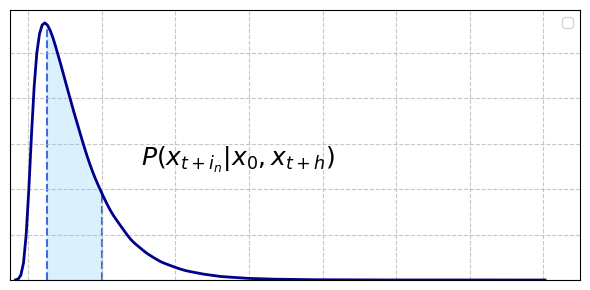

In [285]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import exponweib
from scipy import interpolate

np.random.seed(42)

# Generate data using exponential-Weibull distribution
a1, c1, scale1 = 1.5, 1, 10
size = 500000

data = exponweib.rvs(a1, c1, scale=scale1, size=size)

fig, ax = plt.subplots(figsize=(6, 3))
kde = sns.kdeplot(data, linewidth=2, bw_adjust=1.5, ax=ax, color="darkblue", zorder=2)

ax.set_ylabel("")
ax.set_xlim(-5, 150)
plt.grid(True, linestyle='--', alpha=0.7)

# Remove ticks from all axes
ax.grid(True, linestyle='--', alpha=0.7, zorder=0)

ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.4, 0.5, r'$P(x_{t+i_{n}} | x_{0}, x_{t+h})$', 
        transform=ax.transAxes, fontsize=18, 
        verticalalignment='top', horizontalalignment='center')

# Get the KDE curve data
line = kde.lines[0]
x_data, y_data = line.get_data()

# Create an interpolation function
f = interpolate.interp1d(x_data, y_data)

# Add vertical lines and fill between them
x1, x2 = 5, 20
y1, y2 = f(x1), f(x2)
ax.vlines([x1, x2], 0, [y1, y2], colors=['royalblue', 'royalblue'], linestyles='dashed', zorder=1)
ax.fill_between(np.linspace(x1, x2, 100), 0, f(np.linspace(x1, x2, 100)), alpha=0.3, color='lightskyblue', zorder=0)

plt.legend()
plt.tight_layout()
plt.show()